In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///resource/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12month = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
#last12month

# Calculate the date 1 year ago from the last data point in the database
lastyear = dt.datetime.strptime(last12month, "%Y-%m-%d") - dt.timedelta(days=365)
#lastyear

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.avg(Measurement.prcp)]
prcpdata = session.query(*sel).filter(Measurement.date >= lastyear).group_by(Measurement.date).all()
#prcpdata

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdata_df = pd.DataFrame(prcpdata, columns=["Date", "Precipitiation"])
prcpdata_df.set_index("Date", inplace=True)
#prcpdata_df

# Sort the dataframe by date
#why is this needed if we already did groupby earlier?
prcpdata_df = prcpdata_df.sort_values("Date", ascending=True)
prcpdata_df.head()

,Precipitiation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


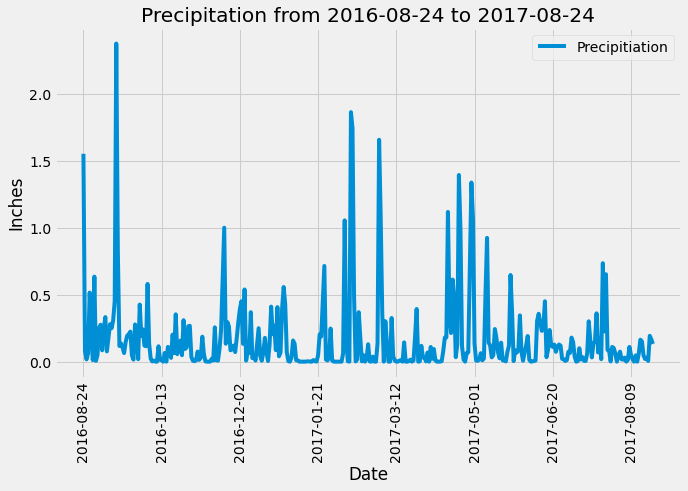

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpdata_df.plot(figsize=(10,6))
plt.title("Precipitation from 2016-08-24 to 2017-08-24")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata_df.describe()

,Precipitiation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(Station.id).count()
print(f"{stationcount} stations present on the Stations data.")

9 stations present on the Stations data.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
activestation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
tempdata_active = session.query(*sel).filter(Measurement.station == activestation[0][0]).all()
#tempdata_active
print(f"Most Active Station ({activestation[0][0]}) Data:")
print(f" Lowest temperature = {tempdata_active[0][0]}")
print(f"Highest temperature = {tempdata_active[0][1]}")
print(f"Average temperature = {tempdata_active[0][2]}")

Most Active Station (USC00519281) Data:
 Lowest temperature = 54.0
Highest temperature = 85.0
Average temperature = 71.66378066378067


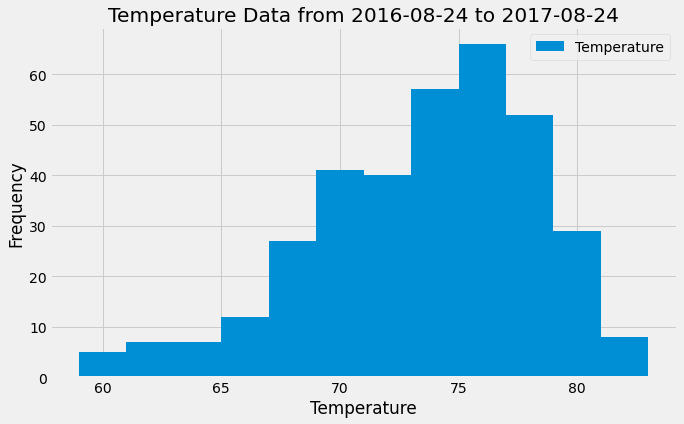

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsobserve = session.query(Measurement.tobs).filter(Measurement.station == activestation[0][0]).\
    filter(Measurement.date >= lastyear).all()

tobsobserve_df = pd.DataFrame(tobsobserve, columns=["Temperature"])
tobsobserve_df.plot(kind="hist", bins=12, figsize=(10,6))
plt.title("Temperature Data from 2016-08-24 to 2017-08-24")
plt.xlabel("Temperature")
plt.show()

In [23]:
last12month = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
lastyear = dt.datetime.strptime(last12month, "%Y-%m-%d") - dt.timedelta(days=365)
activestation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
sel = [Measurement.date, Measurement.tobs]
tempdata = session.query(*sel).filter(Measurement.date >= lastyear).filter(Measurement.station == activestation[0][0]).all()
tempdata

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
